### Import libraries

In [1]:
# Fix randomness and hide warnings
seed = 420

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import math

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [3]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

### Connect to Drive

In [4]:
from google.colab import drive
drive.mount('/gdrive')
os.chdir('/gdrive/My Drive/Colab Notebooks/Challenge 2')

Mounted at /gdrive


In [ ]:
#!unzip training_dataset.zip

### Load and process data

In [5]:
dataset = np.load("training_data.npy", allow_pickle=True)
valid_per = np.load("valid_periods.npy", allow_pickle=True)
cat = np.load("categories.npy", allow_pickle=True)
print(dataset.shape)
print(valid_per.shape)
print(cat.shape)

(48000, 2776)
(48000, 2)
(48000,)


### Inspect Data

In [6]:
unique_elements, counts = np.unique(cat, return_counts=True)
element_counts = dict(zip(unique_elements, counts))
for element, count in element_counts.items():
    print(f"Element {element}: Count {count}")

Element A: Count 5728
Element B: Count 10987
Element C: Count 10017
Element D: Count 10016
Element E: Count 10975
Element F: Count 277


Text(0.5, 1.0, 'C')

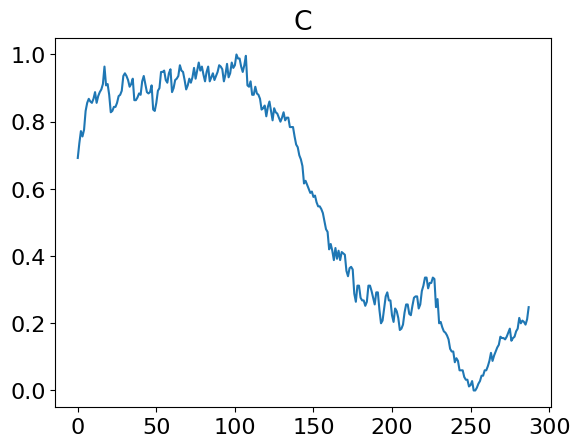

In [7]:
num = 30000
#print(np.linspace(valid_per[num,0], valid_per[num,1]))
plt.plot(dataset[num, np.arange(valid_per[num,0], valid_per[num,1], dtype=int)])
plt.title(cat[num])

In [8]:
dat = np.zeros(len(cat))
n_dataset = {}
for el in unique_elements:
  start = -1
  end = 0
  for i in range(len(cat)):
    if cat[i] == el:
      if start == -1:
        start = i
      end = i
  n_dataset[el] = dataset[start:end, :]
  n_dataset[el+'t'] = valid_per[start:end, :]

In [9]:
max_length = len(cat)
line = 0
for i in range(len(cat)):
  if max_length > valid_per[i, 1]-valid_per[i, 0]:
    max_length = valid_per[i, 1]-valid_per[i, 0]
    line = i
print(max_length, line)

24 47852


In [10]:
mean = np.zeros(len(unique_elements))
variance = np.zeros(len(unique_elements))
for i, el in enumerate(unique_elements):
  mean[i] = np.mean(n_dataset[el+'t'][:, 1]-n_dataset[el+'t'][:, 0])
  variance[i] = np.var(n_dataset[el+'t'][:, 1]-n_dataset[el+'t'][:, 0])
  print(f"Element {el}: Mean {mean[i]} Std dev {np.sqrt(variance[i])}")

Element A: Mean 278.211454513707 Std dev 109.2650103554036
Element B: Mean 165.95357728017476 Std dev 116.13647608799306
Element C: Mean 208.1561501597444 Std dev 146.28606221686587
Element D: Mean 217.00748876684972 Std dev 149.16472997606039
Element E: Mean 163.05622380171314 Std dev 127.9878671656014
Element F: Mean 195.17391304347825 Std dev 153.30423068381918


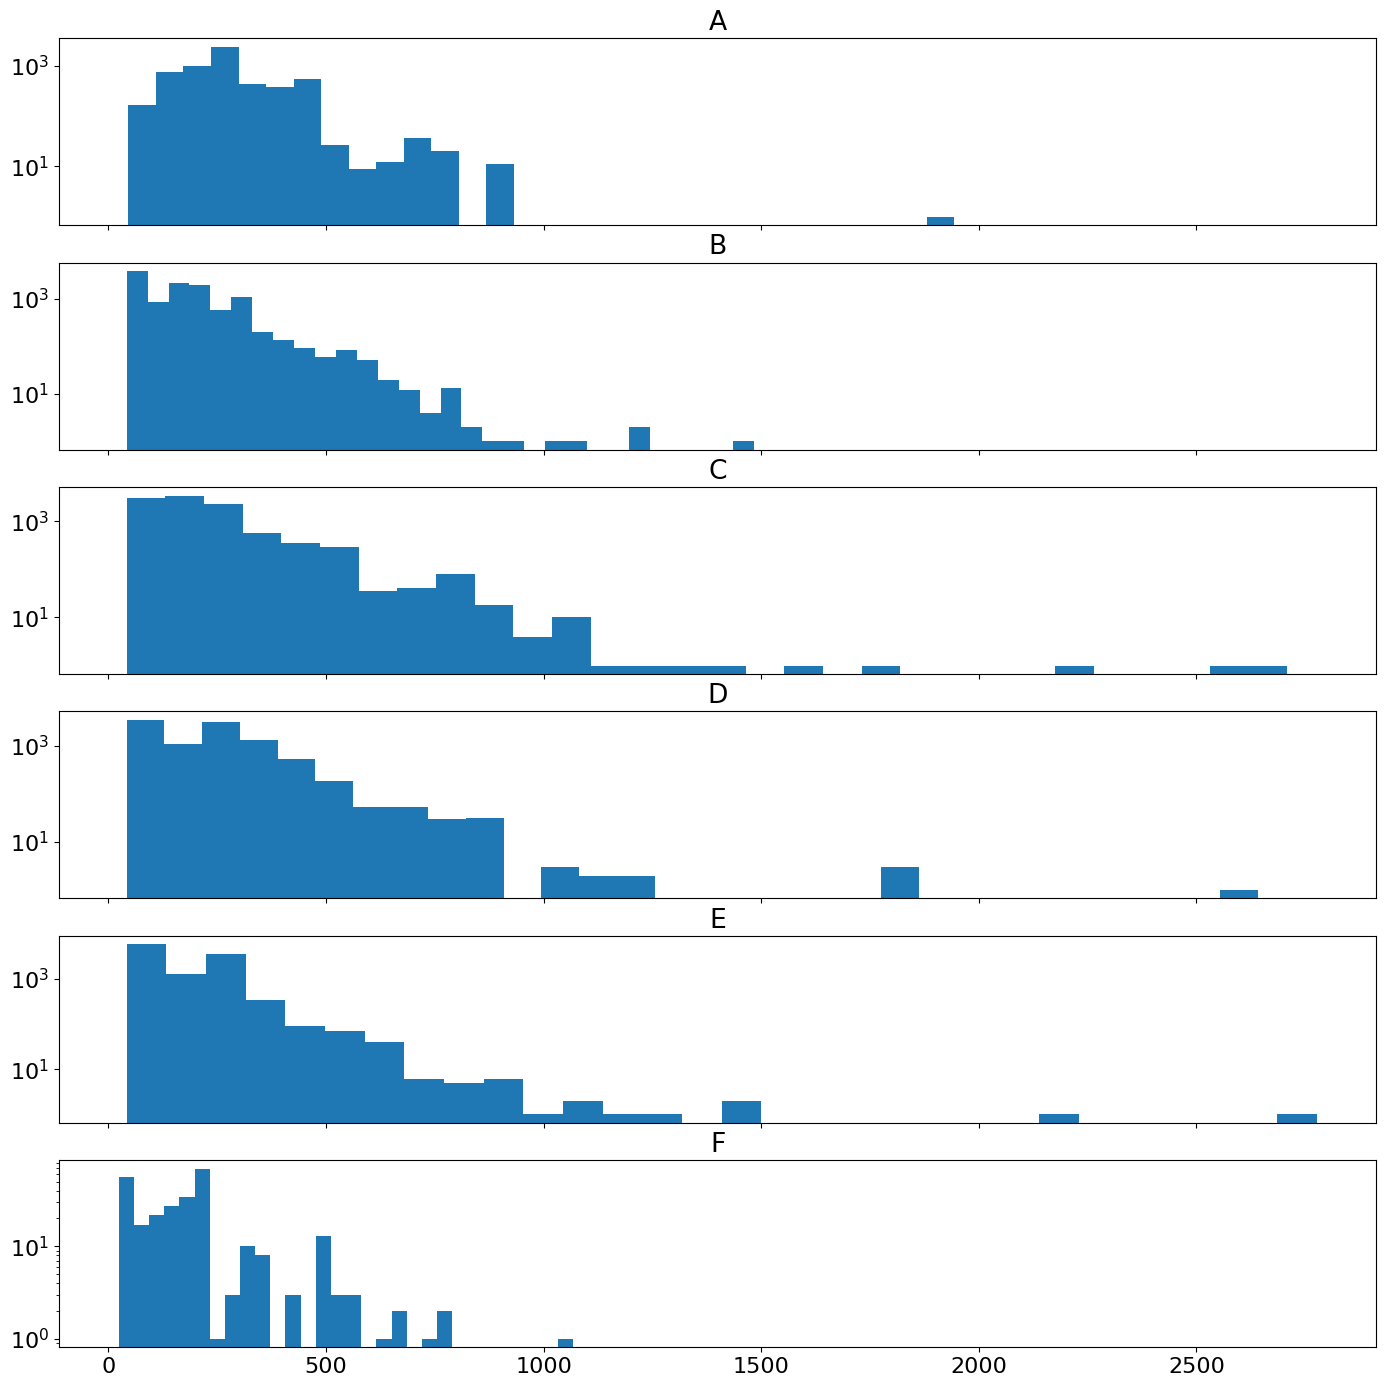

In [11]:
figs, axs = plt.subplots(len(unique_elements), 1, sharex=True, figsize=(17,17))
for i, el in enumerate(unique_elements):
  axs[i].hist(n_dataset[el+'t'][:, 1]-n_dataset[el+'t'][:, 0], bins=30, log=True)
  axs[i].set_title(el)
plt.show()

In [12]:
co = 0
for i in range(len(cat)):
    if valid_per[i, 1]-valid_per[i, 0] > 200+9:
        co = co + 1
print(f"{co/len(cat)*100}%")

45.7%


### Sequential Train-Test split

In [13]:
test_per = 0.2
tv_size = math.ceil(len(dataset)*test_per)

random_indices_test = np.random.choice(len(dataset), size=tv_size, replace=False)
X_test_raw = dataset[random_indices_test]
valid_per_test = valid_per[random_indices_test]
cat_test = cat[random_indices_test]

remain_indices = np.setdiff1d(np.arange(len(dataset)), random_indices_test)
X_train_val = dataset[remain_indices]
valid_per_train_val = valid_per[remain_indices]
cat_train_val = cat[remain_indices]

random_indices_valid = np.random.choice(len(X_train_val), size=tv_size, replace=False)
X_valid_raw = X_train_val[random_indices_valid]
valid_per_valid = valid_per_train_val[random_indices_valid]
cat_valid = cat_train_val[random_indices_valid]

remain_indices = np.setdiff1d(np.arange(len(X_train_val)), random_indices_valid)
X_train_raw = X_train_val[remain_indices]
valid_per_train = valid_per_train_val[remain_indices]
cat_train = cat_train_val[remain_indices]

print(X_train_raw.shape, X_test_raw.shape, X_valid_raw.shape)

(28800, 2776) (9600, 2776) (9600, 2776)


In [14]:
def build_sequences(df, valid, cat, window=200, stride=20, telescope=9):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    n_stride = stride

    for i in range(len(df)):
        val = range(valid[i, 0], valid[i, 1])
        temp_df = df[i, val]
        temp_label = df[i, val]

        if cat[i] == 'F':
          stride = int(n_stride/10)
        else:
          stride = n_stride

        if len(temp_df)<window+telescope:
            padding_len = window + telescope - len(temp_df)
            padding = np.zeros((padding_len), dtype='float32')
            temp_df = np.concatenate((padding,temp_df))
            temp_label = np.concatenate((padding,temp_label))
            assert len(temp_df) % (window+telescope) == 0

        else:
            padding_check = len(temp_df)%window

            if(padding_check != 0):
                # Compute padding length
                padding_len = window - len(temp_df)%window
                padding = np.zeros((padding_len), dtype='float32')
                temp_df = np.concatenate((padding,temp_df))
                temp_label = np.concatenate((padding,temp_label))
                assert len(temp_df) % window == 0

        for idx in np.arange(0,len(temp_df)-window-telescope,stride):
            dataset.append(temp_df[idx:idx+window])
            labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [15]:
telescope_val = 18
stride_val = 10

In [16]:
X_train1, y_train1 = build_sequences(X_train_raw, valid_per_train, cat_train, stride=stride_val, telescope=telescope_val)
X_test1, y_test1 = build_sequences(X_test_raw, valid_per_test, cat_test, stride=stride_val, telescope=telescope_val)
X_valid1, y_valid1 = build_sequences(X_valid_raw, valid_per_valid, cat_valid, stride=stride_val, telescope=telescope_val)
X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape, X_valid1.shape, y_valid1.shape

((287929, 200),
 (287929, 18),
 (97317, 200),
 (97317, 18),
 (95283, 200),
 (95283, 18))

In [17]:
X_train = np.expand_dims(X_train1, axis=-1)
y_train = np.expand_dims(y_train1, axis=-1)
X_test = np.expand_dims(X_test1, axis=-1)
y_test = np.expand_dims(y_test1, axis=-1)
X_valid = np.expand_dims(X_valid1, axis=-1)
y_valid = np.expand_dims(y_valid1, axis=-1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_valid.shape, y_valid.shape

((287929, 200, 1),
 (287929, 18, 1),
 (97317, 200, 1),
 (97317, 18, 1),
 (95283, 200, 1),
 (95283, 18, 1))

In [18]:
def inspect_multivariate(X, y, telescope):
    idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(5, 1, sharex=True, figsize=(17,17))
    for i in range(5):
        axs[i].plot(np.arange(len(X[idx+i,:,0])), X[idx+i,:,0])
        axs[i].scatter(np.arange(len(X[idx+i,:,0]), len(X_train[idx+i,:,0])+telescope), y[idx+i,:,0], color='orange')
        axs[i].set_title(f"{idx+i}")
        #axs[i].set_ylim(0,1)
    plt.show()

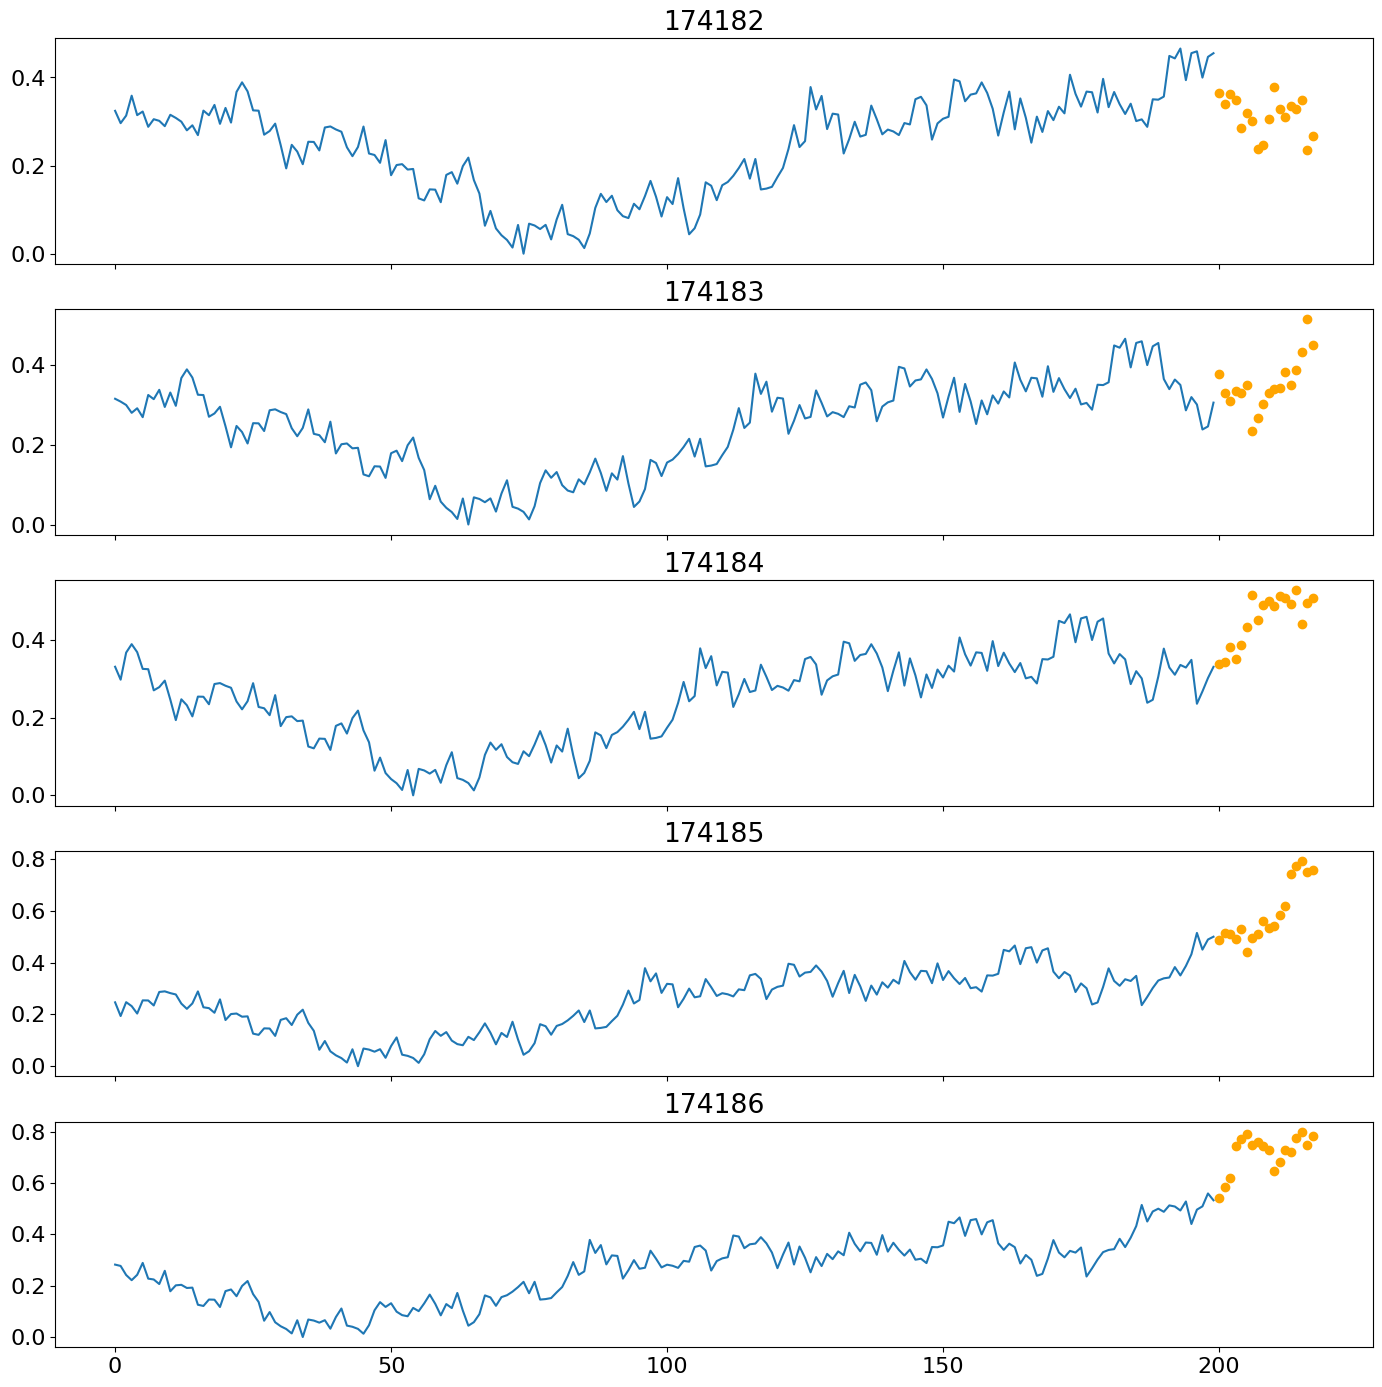

In [19]:
inspect_multivariate(X_train, y_train, 18)

### Monovariate Forecating (Direct)

In [22]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 256
epochs = 200
print(input_shape)

(200, 1)


In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [24]:
def build_CONV_LSTM_model_dense(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(100, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(200, 3, padding='same', activation='relu', name='conv1')(x)

    # Add a final Convolution layer to match the desired output shape
    x = tfkl.Conv1D(output_shape[1], 3, padding='same', name='conv2')(x)

    x = tfkl.Flatten(name='flatten')(x)

    x = tfkl.Dropout(0.5, name='dropout1')(x)

    x = tfkl.Dense(output_shape[0]*2, activation='relu', name='dense1')(x)

    x = tfkl.Dropout(0.3, name='dropout2')(x)

    x = tfkl.Dense(output_shape[0], activation='relu', name='dense2')(x)

    output_layer = tfkl.Reshape((output_shape[0], 1), name='reshape')(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm1')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv1')(x)

    x = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True, name='lstm'), name='bidirectional_lstm2')(x)

    x = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv2')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
def build_CONV_LSTM_model_Att(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm1')(input_layer)

    attention_output = tfkl.Attention()([x, x])

    x = tfkl.Concatenate(axis=-1)([x, attention_output])

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv1')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
def build_LSTM_model_Att_dense(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm1')(input_layer)

    attention_output = tfkl.Attention()([x, x])

    x = tfkl.Concatenate(axis=-1)([x, attention_output])

    x = tfkl.Flatten()(x)

    conc_shape = x.shape[-1]
    num_den = 3
    for i in range(num_den):
      x = tfkl.Dense(math.floor(output_shape[0]*(4**(num_den-i-1))))(x)#(conc_shape/output_shape[0])**(1-(i+1)/num_den)))(x)

    output_layer = tfkl.Reshape((output_shape[0], 1))(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 200)          81600     
 ctional)                                                        
                                                                 
 conv1 (Conv1D)              (None, 200, 200)          120200    
                                                                 
 conv2 (Conv1D)              (None, 200, 1)            601       
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dropout1 (Dropout)          (None, 200)               0         
                                                   

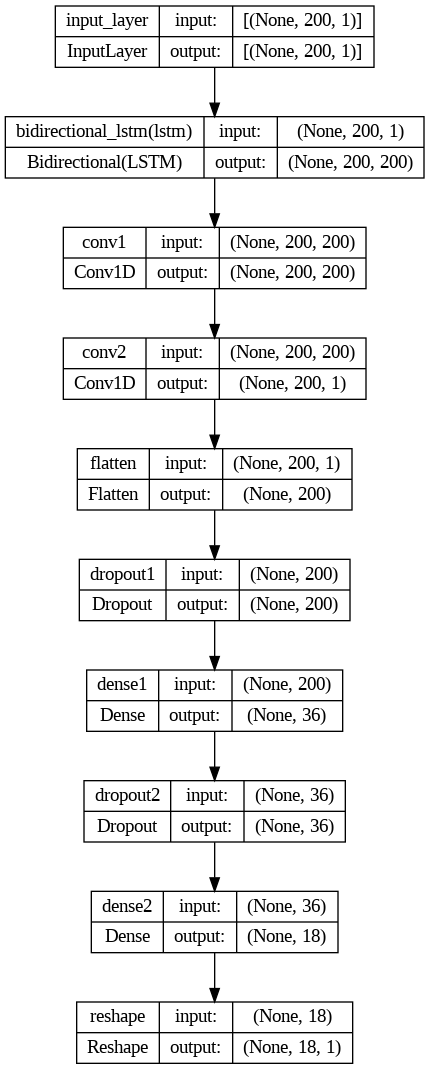

In [25]:
model = build_CONV_LSTM_model_dense(input_shape, output_shape)
#model = tfk.models.load_model('Checkpoints/base_model.keras')
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_valid, y_valid),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=5e-5, patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5),
        tfk.callbacks.ModelCheckpoint(filepath='Checkpoints/base_model.keras')
    ]
).history

Epoch 1/200
1125/1125 [==============================] - 72s 55ms/step - loss: 0.0365 - val_loss: 0.0194 - lr: 0.0010
Epoch 2/200
1125/1125 [==============================] - 61s 54ms/step - loss: 0.0186 - val_loss: 0.0142 - lr: 0.0010
Epoch 3/200
1125/1125 [==============================] - 63s 56ms/step - loss: 0.0165 - val_loss: 0.0119 - lr: 0.0010
Epoch 4/200
1125/1125 [==============================] - 63s 56ms/step - loss: 0.0158 - val_loss: 0.0129 - lr: 0.0010
Epoch 5/200
1125/1125 [==============================] - 63s 56ms/step - loss: 0.0152 - val_loss: 0.0114 - lr: 0.0010
Epoch 6/200
1125/1125 [==============================] - 63s 56ms/step - loss: 0.0147 - val_loss: 0.0116 - lr: 0.0010
Epoch 7/200
1125/1125 [==============================] - 63s 56ms/step - loss: 0.0146 - val_loss: 0.0115 - lr: 0.0010
Epoch 8/200
1125/1125 [==============================] - 63s 56ms/step - loss: 0.0147 - val_loss: 0.0112 - lr: 0.0010
Epoch 9/200
1125/1125 [==============================] -

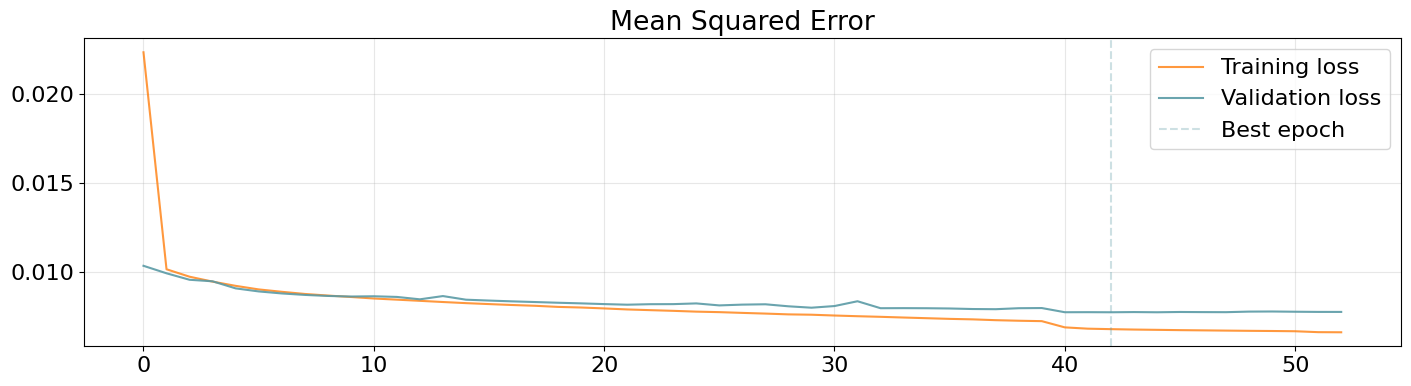

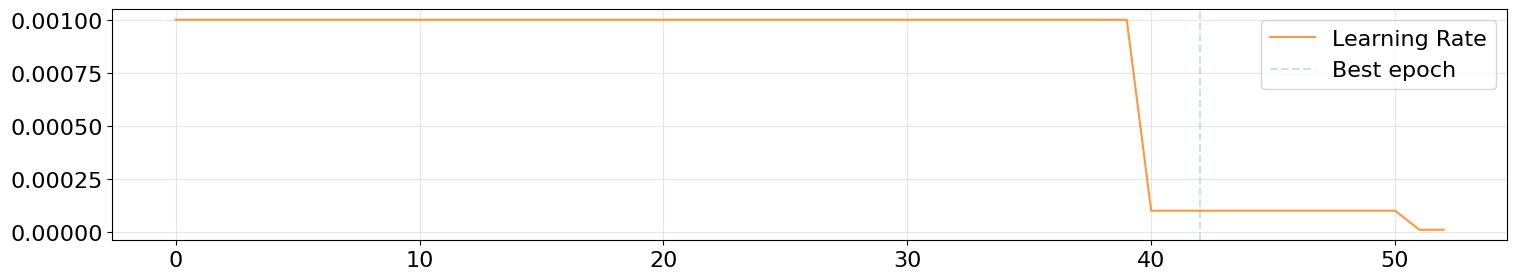

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('DirectForecasting7dr.h5')
#model = tfk.models.load_model('DirectForecasting')

Test evaluation

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (97317, 18, 1)
Mean Squared Error: 0.007836676202714443
Mean Absolute Error: 0.056355640292167664


In [ ]:
pred2 = np.argmax(predictions, axis = -1)
pred2 = pred2[:, :9]
pred2.shape

(124314, 9)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    pred = np.concatenate([np.expand_dims(X[:,-1,:],axis=1),pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1,:],axis=1),y],axis=1)

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i])-1, len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i])-1, len(X[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, direct_telescope)

NameError: ignored

Predict the future

In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
future_predictions = model.predict(future,verbose=0)
future_predictions = np.concatenate([np.expand_dims(future[:,-1,:],axis=0),future_predictions],axis=1)
maes = np.concatenate([np.array([[0,0,0]]),maes],axis=0)

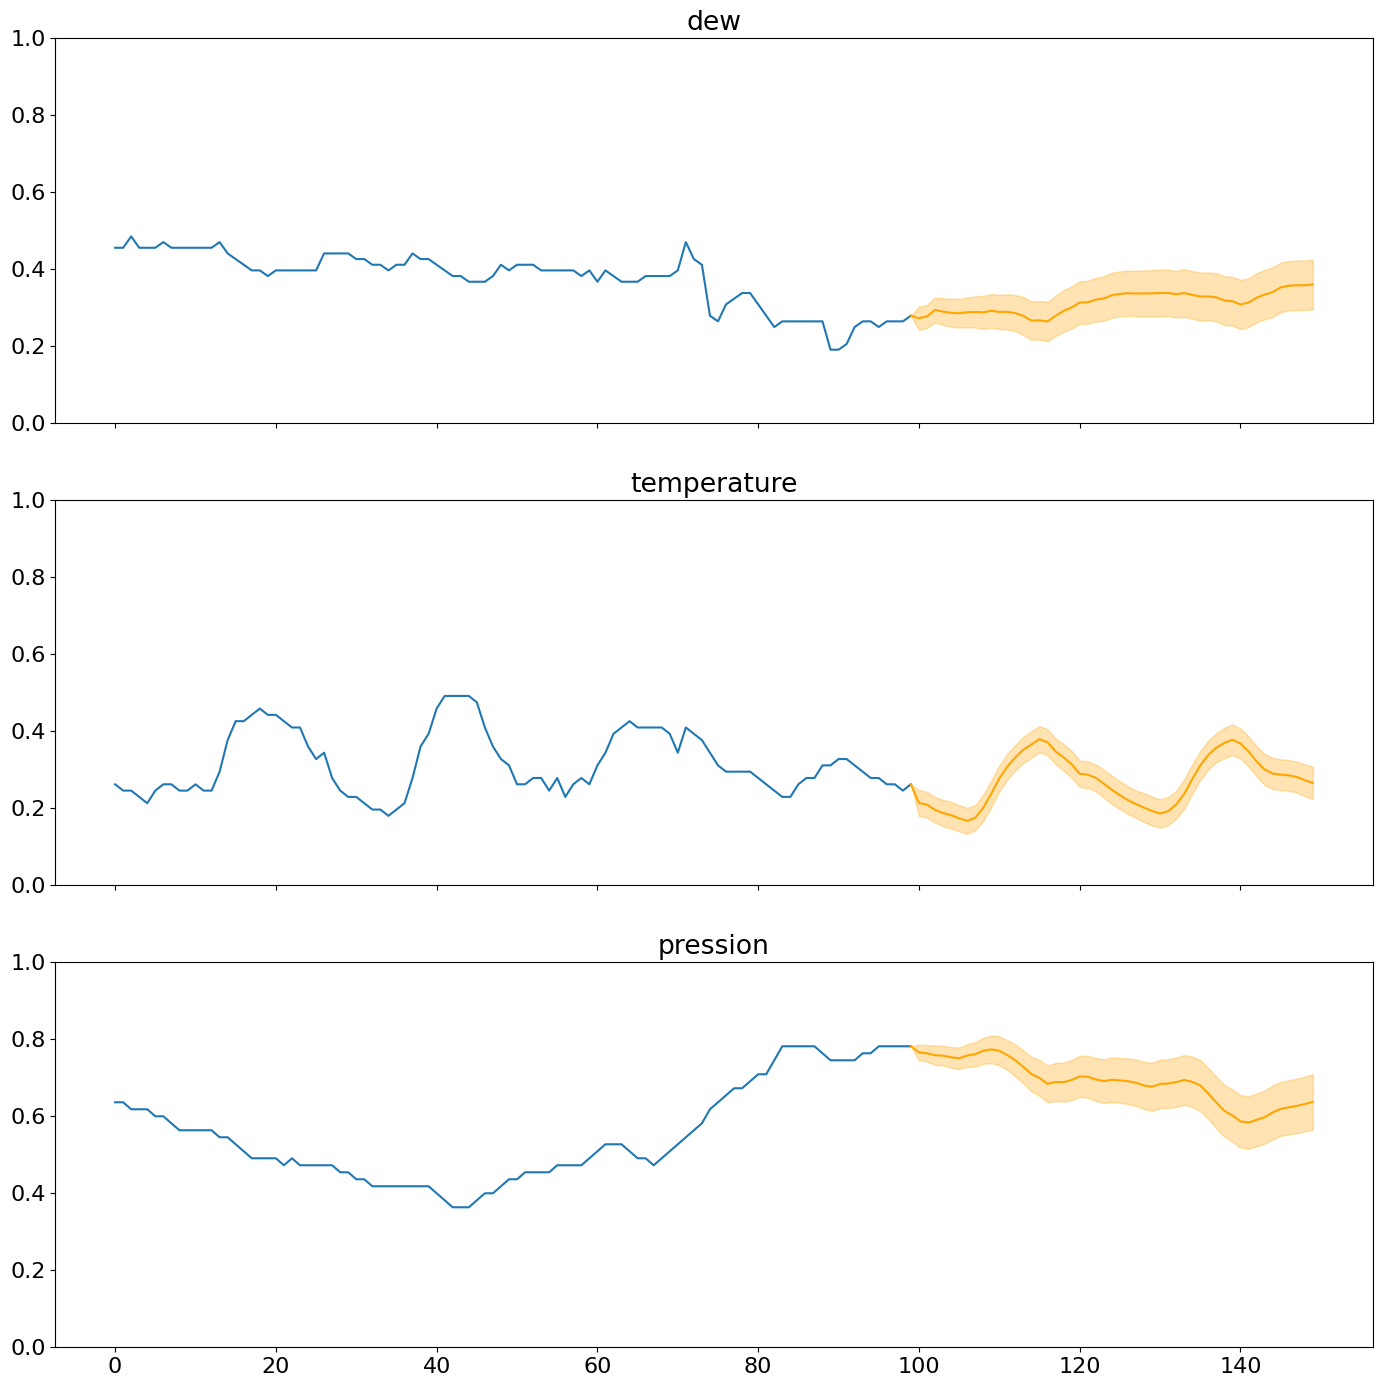

In [ ]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i])-1, len(future[0,:,i])+direct_telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i])-1, len(future[0,:,i])+direct_telescope),
        future_predictions[0,:,i]+maes[:,i],
        future_predictions[0,:,i]-maes[:,i],
        color='orange', alpha=.3)
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
plt.show()

### Multivariate Forecasting (Autoregression)

In [ ]:
autoregressive_telescope = 10
assert autoregressive_telescope < telescope

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, autoregressive_telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, autoregressive_telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7978, 100, 3), (7978, 10, 3), (738, 100, 3), (738, 10, 3))

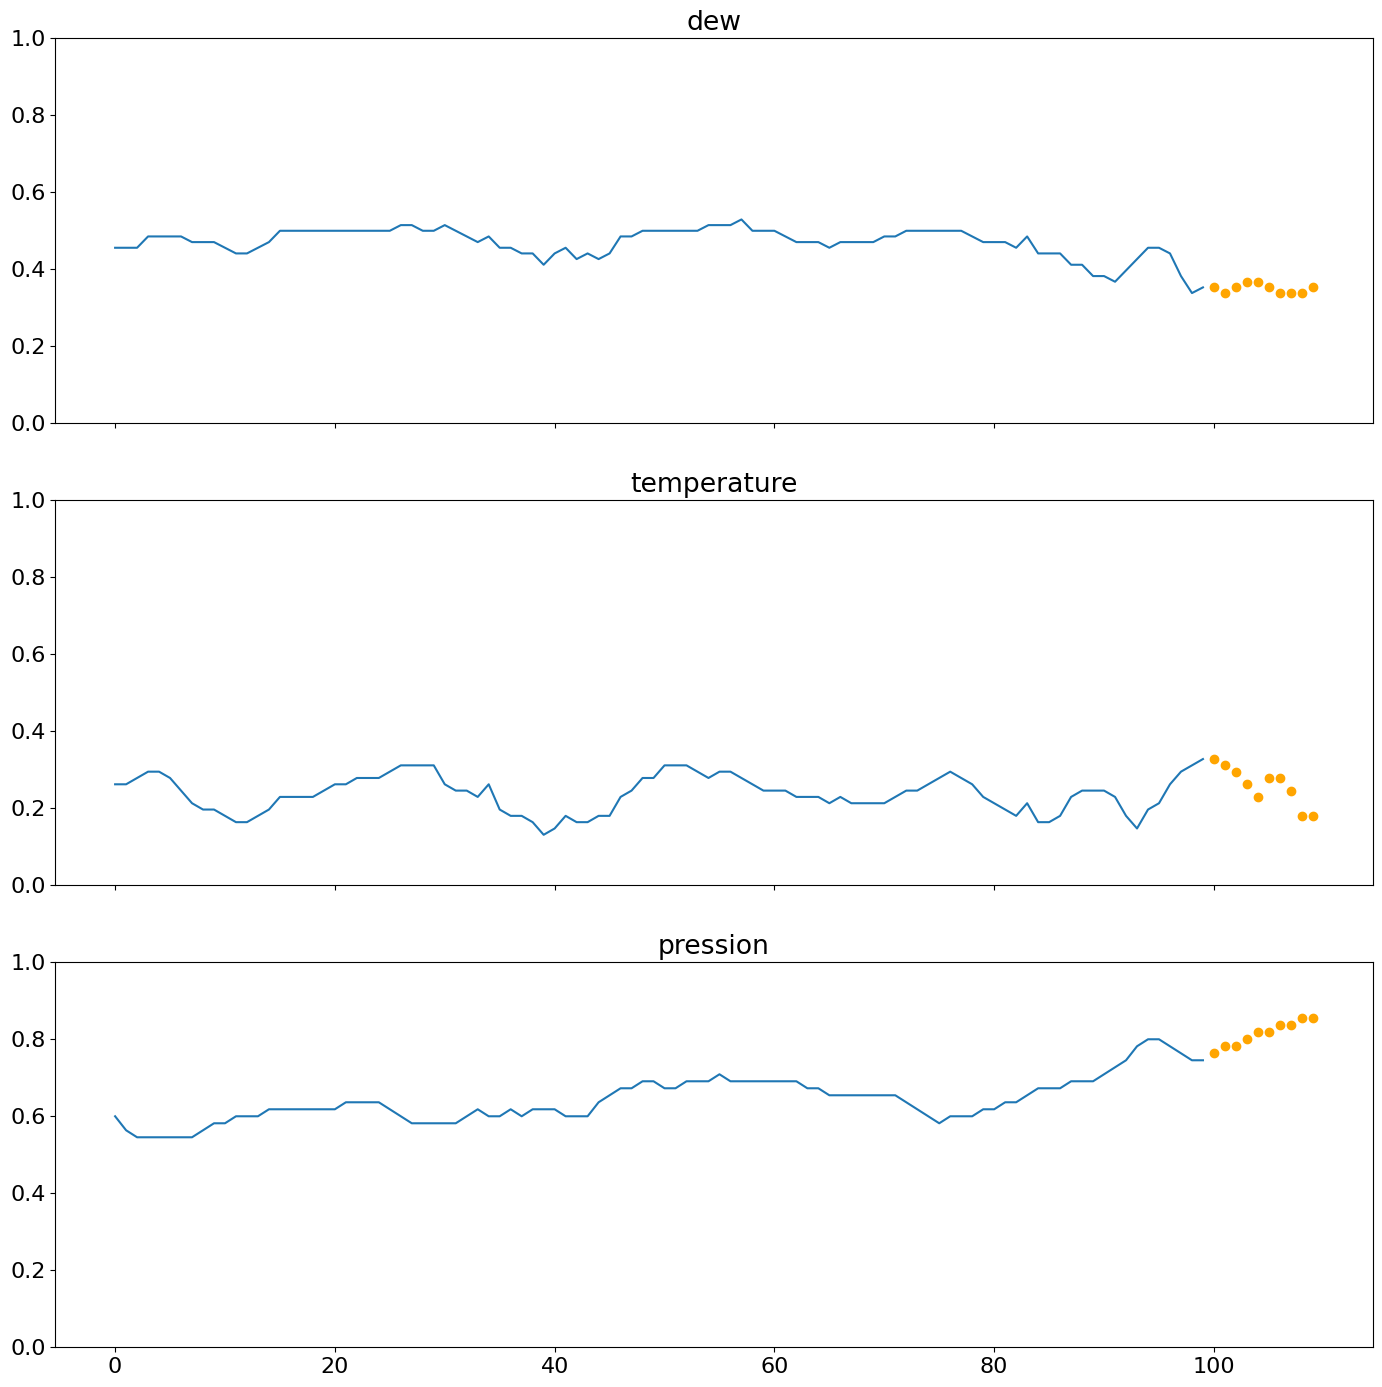

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, autoregressive_telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100, 3)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 100, 128)          34816     
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 100, 128)          49280     
                                                                 
 output_layer (Conv1D)       (None, 100, 3)            1155      
                                                                 
 cropping (Cropping1D)       (None, 10, 3)             0         
                                                                 
Total params: 85251 (333.01 KB)
Trainable params: 85251 (333.01 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

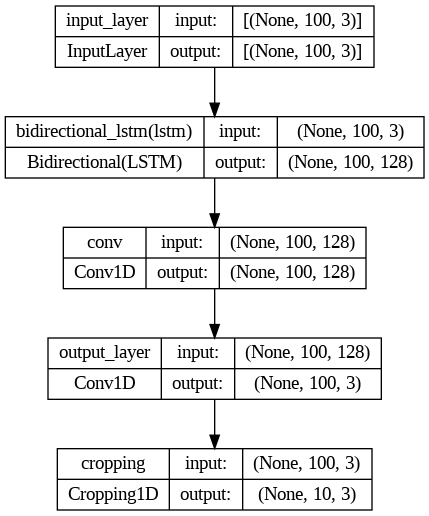

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
113/113 [==============================] - 6s 19ms/step - loss: 0.0213 - val_loss: 0.0092 - lr: 0.0010
Epoch 2/200
113/113 [==============================] - 1s 11ms/step - loss: 0.0092 - val_loss: 0.0076 - lr: 0.0010
Epoch 3/200
113/113 [==============================] - 1s 12ms/step - loss: 0.0085 - val_loss: 0.0088 - lr: 0.0010
Epoch 4/200
113/113 [==============================] - 1s 11ms/step - loss: 0.0079 - val_loss: 0.0076 - lr: 0.0010
Epoch 5/200
113/113 [==============================] - 1s 12ms/step - loss: 0.0074 - val_loss: 0.0063 - lr: 0.0010
Epoch 6/200
113/113 [==============================] - 2s 15ms/step - loss: 0.0071 - val_loss: 0.0075 - lr: 0.0010
Epoch 7/200
113/113 [==============================] - 2s 16ms/step - loss: 0.0067 - val_loss: 0.0074 - lr: 0.0010
Epoch 8/200
113/113 [==============================] - 2s 15ms/step - loss: 0.0067 - val_loss: 0.0066 - lr: 0.0010
Epoch 9/200
113/113 [==============================] - 2s 15ms/step - loss: 0.00

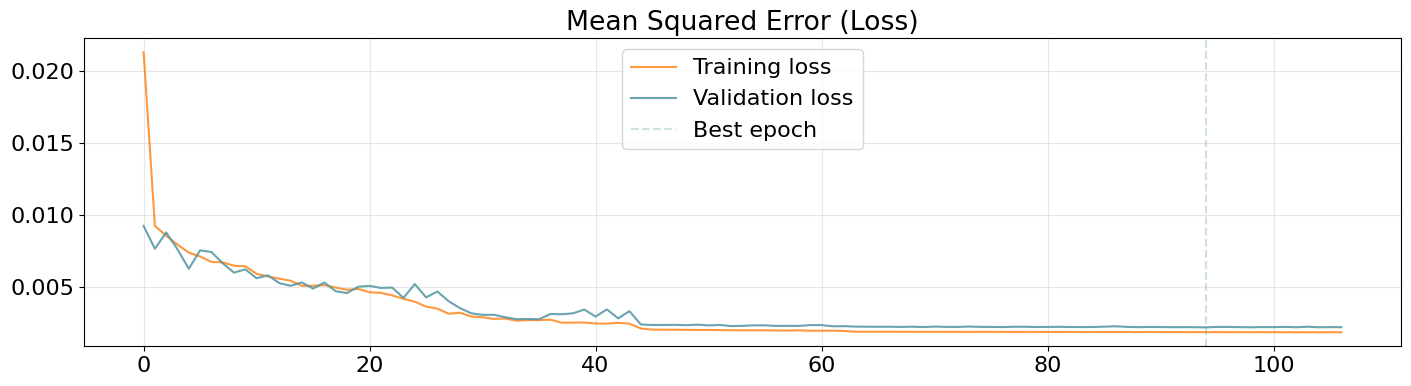

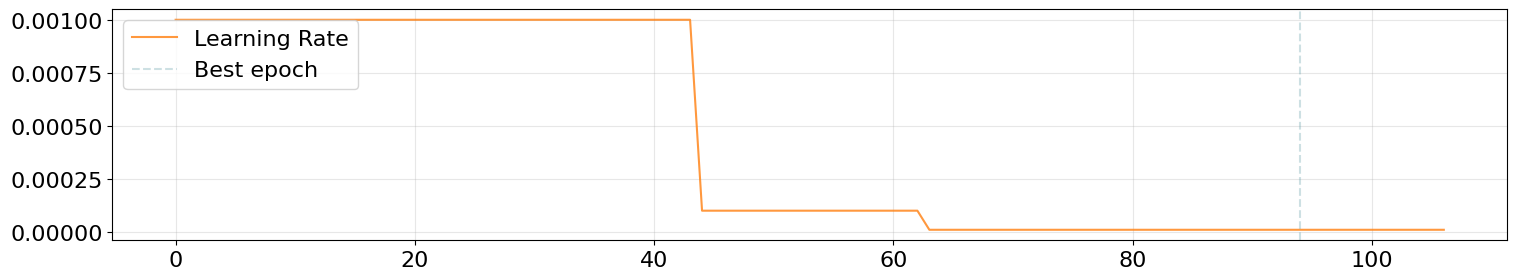

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# model.save('AuroregressiveForecasting')
model = tfk.models.load_model('AuroregressiveForecasting')

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (738, 10, 3)
Mean Squared Error: 0.0015956070274114609
Mean Absolute Error: 0.029108045622706413


In [ ]:
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_test_reg.shape, y_test_reg.shape

((730, 100, 3), (730, 50, 3))

In [ ]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,telescope,autoregressive_telescope):
    pred_temp = model.predict(X_temp,verbose=0)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,autoregressive_telescope:,:],pred_temp), axis=1)

In [ ]:
# Print the shape of the predictions
print(f"Predictions shape: {reg_predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test_reg.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test_reg.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (730, 50, 3)
Mean Squared Error: 0.0045051067136228085
Mean Absolute Error: 0.04832511022686958


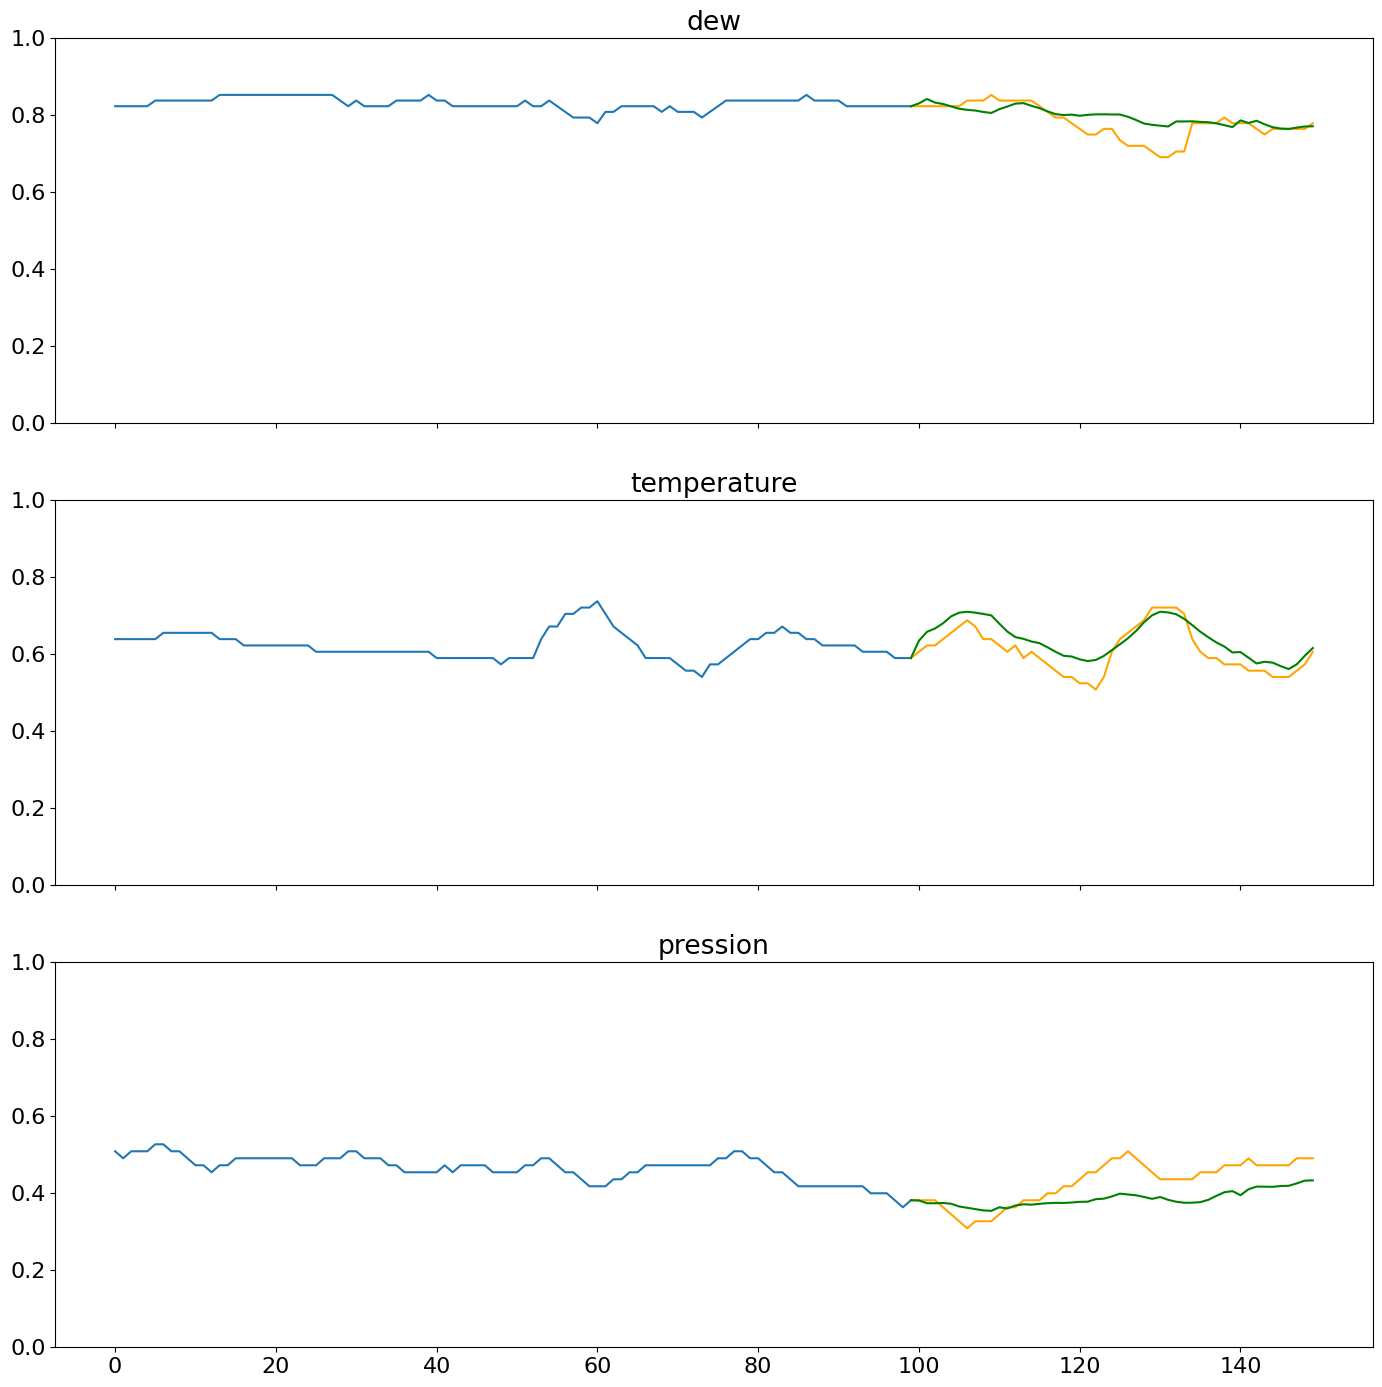

In [ ]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, telescope)

predict the future

In [ ]:
maes = []
for i in range(reg_predictions.shape[1]):
    ft_maes = []
    for j in range(reg_predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test_reg[:,i,j]-reg_predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
# Autoregressive Forecasting (Future)
reg_future = np.array([])
X_temp = future # The sequence to forecast
for reg in range(0,telescope,autoregressive_telescope): # For each telescope step (i.e., reg_telescope%telescope is preferred to be 0)
    pred_temp = model.predict(X_temp,verbose=0) # Predict the current sequence
    if(len(reg_future)==0):
        reg_future = pred_temp # Initialize the forecasting
    else:
        reg_future = np.concatenate((reg_future,pred_temp),axis=1) # Append the prediction to the whole forecasting
    X_temp = np.concatenate((X_temp[:,autoregressive_telescope:,:],pred_temp), axis=1) # Shift the input of the next predict so that the just predicted sequence is at the end of the input, and the dimention is correct

In [ ]:
reg_future = np.concatenate([np.expand_dims(future[:,-1,:],axis=0),reg_future],axis=1)
maes = np.concatenate([np.array([[0,0,0]]),maes],axis=0)

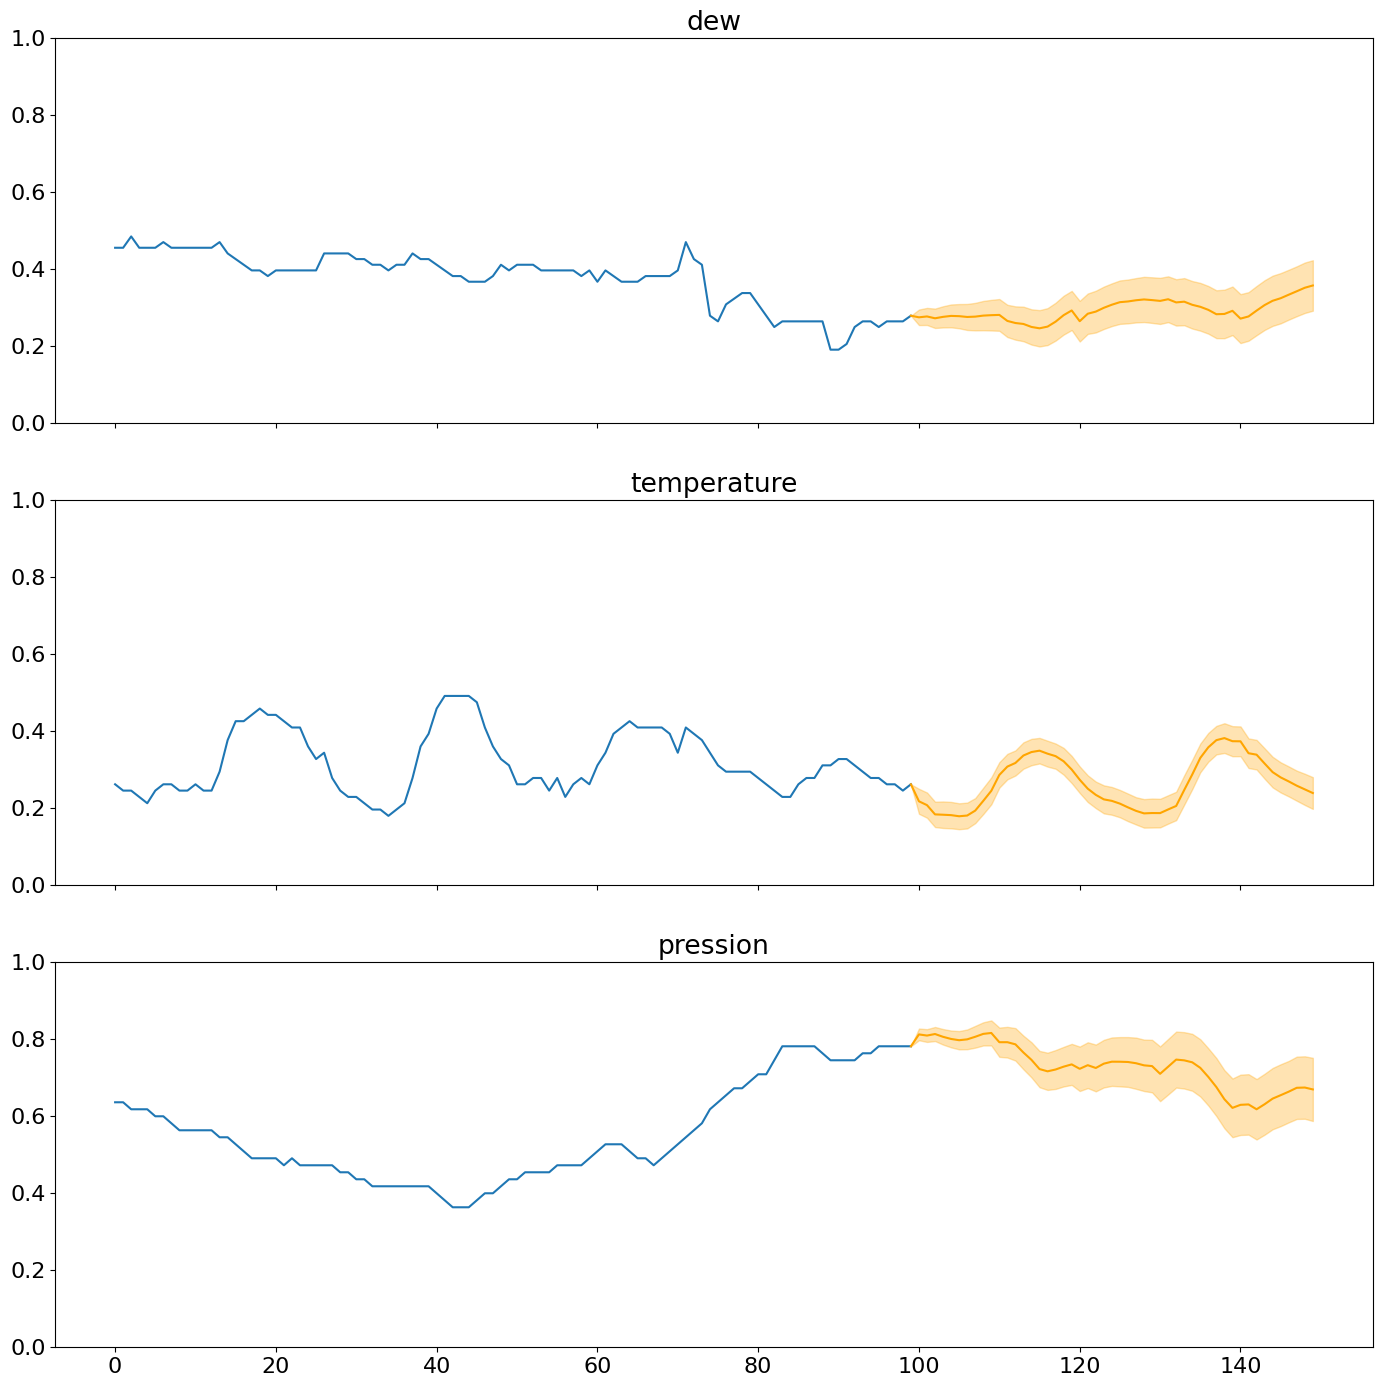

In [ ]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i])-1, len(future[0,:,i])+telescope), reg_future[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i])-1, len(future[0,:,i])+telescope),
        reg_future[0,:,i]+maes[:,i],
        reg_future[0,:,i]-maes[:,i],
        color='orange', alpha=.3)
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
plt.show()

Try realising new architectures with recurrent and convolutional blocks, perhaps inspired by the CNNs seen in previous lessons. And remember: Attention may be all you need, semicit.

*Credits: Eugenio Lomurno, 📧 eugenio.lomurno@polimi.it*